# Polygon area calculation

from [this SO page](https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates).

In [8]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import simps

In [9]:
def poly_area(x,y):
    """Implementation of Shoelace formula
    Args:
        x, y: coordinate vectors [array-like]
        Coordinate vectors *MUST BE* provided in an ordered (clockwise/counter clockwise) manner
        example: x, y = np.array([[3, 5, 12, 9, 5, 3], [4, 11, 8, 5, 6, 4]])
    Return:
        area: [float]
    References:
        https://en.wikipedia.org/wiki/Shoelace_formula
        https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
    """
    return 0.5 * np.abs(np.dot(x, np.roll(y,1)) - np.dot(y, np.roll(x,1)))

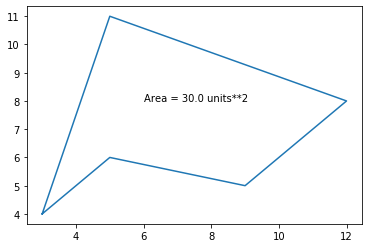

In [10]:
# https://en.wikipedia.org/wiki/Shoelace_formula
test_coords = np.array([[3, 5, 12, 9, 5, 3], [4, 11, 8, 5, 6, 4]])
assert poly_area(test_coords[0], test_coords[1]) == 30
plt.plot(test_coords[0], test_coords[1])
plt.text(6, 8, f'Area = {poly_area(test_coords[0], test_coords[1])} units**2')
plt.show()

## Extension to area-depth

### First define some polygons:

In [11]:
# x, y vectors
top_0 = np.array([[8, 8, 8, 8, 8], [8, 8, 8, 8, 8]])
top_1 = np.array([[7, 9, 9, 7, 7], [7, 7, 9, 9, 7]])
top2_goc = np.array([[6, 10, 10, 6, 6], [6, 6, 10, 10, 6]])
top3 = np.array([[5, 11, 11, 5, 5], [5, 5, 11, 11, 5]])
top4 = np.array([[4, 12, 12, 4, 4], [4, 4, 12, 12, 4]])
top5_owc = np.array([[3, 13, 13, 3, 3], [3, 3, 13, 13, 3]])
# depths of polygons
depths = np.array([-1200, -1250, -1380, -1500, -1590, -1720])

## Calculate areas for each contour

In [12]:
def calc_areas_from_countour_set(*contour_sets):
    """Calculate poly_area for each contour
    Args:
        contour_sets: contours, positional args of type `np.array([[...],[...]]`
    Returns:
        areas: array of areas
        contour_set: tuple of inputs
    """
    areas = np.array([poly_area(c[0], c[1]) for c in np.array(contour_sets)])
    print(f'areas.shape: {areas.shape}')
    return areas, (contour_sets)

In [13]:
areas, cs = calc_areas_from_countour_set(top_0, top_1, top2_goc, top3, top4, top5_owc)
print(f'\nareas: {areas}\n\ncontour sets:\n{cs}')

areas.shape: (6,)

areas: [  0.   4.  16.  36.  64. 100.]

contour sets:
(array([[8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8]]), array([[7, 9, 9, 7, 7],
       [7, 7, 9, 9, 7]]), array([[ 6, 10, 10,  6,  6],
       [ 6,  6, 10, 10,  6]]), array([[ 5, 11, 11,  5,  5],
       [ 5,  5, 11, 11,  5]]), array([[ 4, 12, 12,  4,  4],
       [ 4,  4, 12, 12,  4]]), array([[ 3, 13, 13,  3,  3],
       [ 3,  3, 13, 13,  3]]))


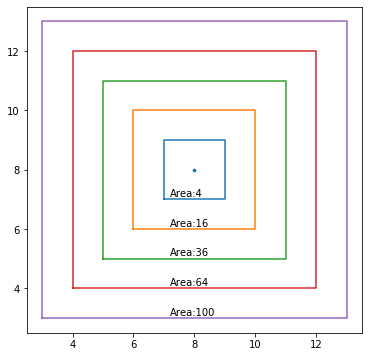

In [14]:
# plot for QC
fig = plt.figure(figsize=(6, 6))
plt.scatter(top_0[0], top_0[1], s=5)
for c in cs[1:]:
    plt.plot(c[0], c[1])
    plt.text(7.2, c[0,0] + 0.1, f'Area:{poly_area(c[0], c[1]):.0f}')

### Add contacts

Define some depths in tvdss, but shift them to zero for integration of area under curve

In [15]:
goc, owc = -1380, -1720
depths

array([-1200, -1250, -1380, -1500, -1590, -1720])

## Calculate `grv` using the `poly_area`

Here I calculate grv using the `poly_area` function rather than `np.trapz` or `scipy.integrate.simps`.
First a comparison of the three methods on a simple case:

### Test case to compare methods

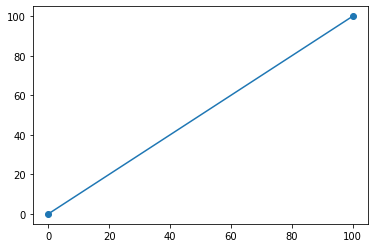

In [16]:
topx = [0, 100]
topy = [0, 100]
plt.plot(topy, topx, 'o-')

In [17]:
#area under curve
100 * 100 / 2

5000.0

In [18]:
# area from np.trapz
np.trapz(topx, topy)

5000.0

In [19]:
# area from simps
simps(topx, topy)

5000.0

In [20]:
# area from poly_area, we need to complete the xs and ys
xs = [0, 100, 100, 0]
ys = [0, 0, 100, 0]
poly_area(xs, ys)

5000.0

###  Example case 1: top, no base, no goc

In [21]:
print(f'areas: {areas}\ndepths: {depths}\ngoc: {goc}\nowc: {owc}')

areas: [  0.   4.  16.  36.  64. 100.]
depths: [-1200 -1250 -1380 -1500 -1590 -1720]
goc: -1380
owc: -1720


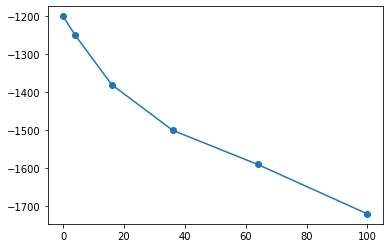

In [43]:
plt.plot(areas, depths, 'o-')

In [23]:
np.trapz(areas, depths), simps(areas, depths)

(-19680.0, -19466.54131054131)

In [24]:
def build_poly_from_area_depth(areas, depths):
    """Build polygon from area depth data"""
    xs = np.append(areas, np.flip(areas)[1:])
    ys = [depths[-1]] * len(areas)
    ys = np.append(ys, np.flip(depths)[1:])
    return xs, ys

In [25]:
poly_area(*build_poly_from_area_depth(areas, depths))

19680.0

### Example case 2: top, base, no goc

We use areas and depths as before, shift the dephts down by 100 units, and then need to calculate the base_contact_interesct to add a point to the polygon.

In [26]:
areas, depths

(array([  0.,   4.,  16.,  36.,  64., 100.]),
 array([-1200, -1250, -1380, -1500, -1590, -1720]))

In [27]:
base_depths = depths - 100
base_depths

array([-1300, -1350, -1480, -1600, -1690, -1820])

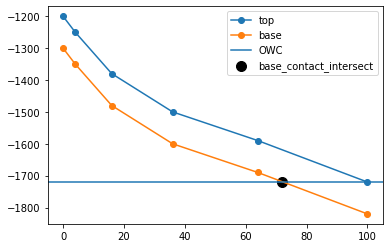

In [28]:
plt.plot(areas, depths, '-o', label='top')
plt.plot(areas, base_depths, '-o', label='base')
plt.axhline(owc, label='OWC')
plt.scatter(72, -1720, marker='o', c='k', s=100, label='base_contact_intersect')
plt.legend()

### `base_contact_intersect` calculation

In [29]:
def closest_depths_to_contact(arr, contact):
    """Get closest depths to contact in an array"""
    close_0 = arr.flat[np.abs(arr - contact).argmin()]
    arr2 = arr[arr != close_0]
    close_1 = arr2.flat[np.abs(arr2 - contact).argmin()]
    return close_0, close_1


def closest_areas_to_contact(arr, c0, c1):
    """Get equivalent closest areas to contact"""
    area_0 = areas[np.where(arr == c0)][0]
    area_1 = areas[np.where(arr == c1)][0]
    return area_0, area_1


def last_base_slope(c0, c1, a0, a1):
    """Calculate slope of line"""
    dy = c1 - c0
    dx = a1 - a0
    return dy / dx


def calc_x_for_contact_depth(m, c, contact):
    """Calculate x for contact depth
    Args:
        m: slope from `last_base_slope`
        c: intercept from `c0`
    """
    return 1 / m * (contact - c)


def calc_x_actual(x, a0):
    """Calculate x position of intersection of base with contact"""
    return x + a0


def build_poly_from_top_depth_contact(areas, top_depths, base_depths, x_act, contact):
    """Build polygon from top depth and contact"""
    xs = np.append(np.append(areas[:-1], x_act), areas[::-1])
    ys = np.append(np.append(base_depths[:-1], contact), top_depths[::-1])
    return xs, ys

In [30]:
c0, c1 = closest_depths_to_contact(base_depths, owc)
a0, a1 = closest_areas_to_contact(base_depths, c0, c1)
m = last_base_slope(c0, c1, a0, a1)
x = calc_x_for_contact_depth(m, c0, owc)
x_act_owc = calc_x_actual(x, a0)

72.3076923076923 -1720


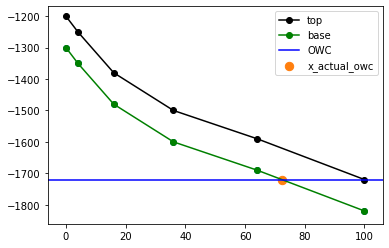

In [31]:
plt.plot(areas, depths, '-o', c='k', label='top')
plt.plot(areas, base_depths, '-o', c='g', label='base')
plt.scatter(areas, base_depths)
plt.axhline(owc, c='b', label='OWC')
plt.scatter(x_act_owc, owc, s=70, label='x_actual_owc')
plt.legend()
print(x_act_owc, owc)

In [32]:
print(f'areas: {areas}\ndepths: {depths}\nbase: {base_depths}\nx_actual:depth: {x_act_owc, owc}')

areas: [  0.   4.  16.  36.  64. 100.]
depths: [-1200 -1250 -1380 -1500 -1590 -1720]
base: [-1300 -1350 -1480 -1600 -1690 -1820]
x_actual:depth: (72.3076923076923, -1720)


In [33]:
xs, ys = build_poly_from_top_depth_contact(areas, depths, base_depths, x_act_owc, owc)
HCGRV = poly_area(xs, ys)
HCGRV

8615.384615384624

### `base_contact_intersect` calculation: GOC

In [34]:
c0, c1 = closest_depths_to_contact(base_depths, goc)
a0, a1 = closest_areas_to_contact(base_depths, c0, c1)
m = last_base_slope(c0, c1, a0, a1)
x = calc_x_for_contact_depth(m, c0, goc)
x_act_goc = calc_x_actual(x, a0)

6.4 -1380


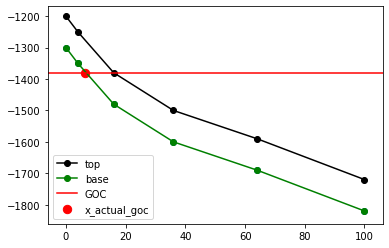

In [35]:
plt.plot(areas, depths, '-o', c='k', label='top')
plt.plot(areas, base_depths, '-o', c='g', label='base')
plt.scatter(areas, base_depths)
plt.axhline(goc, c='r', label='GOC')
plt.scatter(x_act_goc, goc, c='r', s=70, label='x_actual_goc')
plt.legend()
print(x_act_goc, goc)

In [36]:
# insert x_act_goc into areas and depths vectors
idx_areas_xgoc = np.searchsorted(areas, x_act_goc)
areas_goc = np.insert(areas, idx_areas_xgoc, x_act_goc)
idx_base_depths_goc = np.searchsorted(base_depths[::-1], goc)
base_depths_goc = np.insert(base_depths[::-1], idx_base_depths_goc, goc)[::-1]

In [37]:
print(f"""areas: {areas}
depths: {depths}
areas_goc: {areas_goc}
base_depths_goc: {base_depths_goc}
goc: {goc}
x_act_goc: {x_act_goc}""")

areas: [  0.   4.  16.  36.  64. 100.]
depths: [-1200 -1250 -1380 -1500 -1590 -1720]
areas_goc: [  0.    4.    6.4  16.   36.   64.  100. ]
base_depths_goc: [-1300 -1350 -1380 -1480 -1600 -1690 -1820]
goc: -1380
x_act_goc: 6.4


In [38]:
base_xs = areas_goc[areas_goc <= x_act_goc]
base_ys = base_depths_goc[base_depths_goc >= goc]

In [39]:
top_xs = areas[depths >= goc]
top_ys = depths[depths >= goc]

In [40]:
base_xs, top_xs, base_ys, top_ys

(array([0. , 4. , 6.4]),
 array([ 0.,  4., 16.]),
 array([-1300, -1350, -1380]),
 array([-1200, -1250, -1380]))

In [41]:
goc_xs = np.append(base_xs, top_xs[::-1])
goc_ys = np.append(base_ys, top_ys[::-1])
GOCGRV = poly_area(goc_xs, goc_ys)
GOCGRV

1144.0

In [42]:
GRV = HCGRV - GOCGRV
GRV

7471.384615384624